In [58]:
import requests
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import networkx as nx

import sys
sys.path.append("../graph_signal_processing")

from learn_heat import learn_heat
from gls_sig_rep import GLSigRep

from cvxopt import solvers
solvers.options['show_progress'] = False

!pip install quandl

import quandl
quandl.ApiConfig.api_key = "2kxjjXzEv58TxF_LF6Nj" 

In [13]:
kwargs = {"start_date" : "2018-01-01", 
        "end_data" : "2021-01-01", 
        "collapse" : "daily",
        "transform" : "rdiff"}

tickers = {"Gold" : "LBMA/GOLD", 
           "Silver": "LBMA/SILVER", 
           "ETH" : "BITFINEX/ETHUSD", 
           "BTC" : "BITFINEX/BTCUSD", 
           "LTC" : "BITFINEX/LTCBTC", 
           "ZEC" : "BITFINEX/ZECUSD", 
           "Paladium" : "LPPM/PALL", 
           "Platine" : "LPPM/PLAT", 
           "BNP Paribas" : "EURONEXT/BNP", 
           "Crédit Agricole" : "EURONEXT/ACA", 
           "Société Générale" : "EURONEXT/GLE", 
           "Natixis" : "EURONEXT/KN",
           "Hermes" : "EURONEXT/RMS",
           "Kering" : "EURONEXT/KER",
           "LVMH" : "EURONEXT/MC",
        }

In [14]:
brut_dfs = {key : quandl.get(tickers[key], **kwargs) for key in tickers.keys()}

In [55]:
import pandas as pd

df = pd.DataFrame(index=brut_dfs["BTC"].index)

columns_of_interest = {"Gold" : "USD (AM)", 
                       "Silver" : "USD",
                       "ETH" : "Mid", 
                       "BTC" : "Mid", 
                       "LTC" : "Mid", 
                       "ZEC" : "Mid", 
                       "Paladium" : "USD AM",
                       "Platine" : "USD AM",
                       "BNP Paribas" : "Open",
                       "Crédit Agricole" : "Open",
                       "Société Générale" : "Open",
                       "Natixis" : "Open",
                       "Hermes" : "Open",
                       "Kering" : "Open",
                       "LVMH" : "Open",
                      }

for key in columns_of_interest.keys():
    df_ = brut_dfs[key][columns_of_interest[key]]
    df[key] = df_

df = df.dropna()

In [62]:
keys_tickers = list(columns_of_interest)

In [86]:

L_heat, H_heat, tau_heat = learn_heat(df.values, n_step=3000, alpha=1e-3, beta=1e-3, s=1)

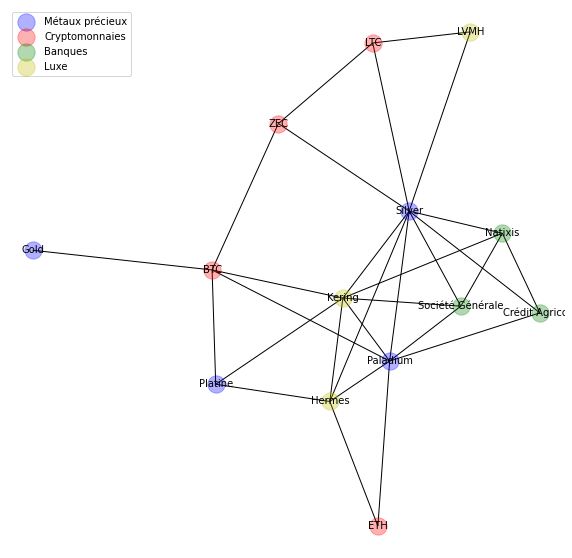

In [94]:
pruned_L_heat = np.copy(L_heat)
pruned_L_heat[np.abs(L_heat) < 0.1] = 0

G = nx.Graph()

for key in tickers.keys():
    G.add_node(key)

for i in range(len(keys_tickers)):
    for j in range(i+1, len(keys_tickers)):
        if pruned_L_heat[i, j] != 0:
            G.add_edge(keys_tickers[i], keys_tickers[j])
            
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, nodelist=["Gold", "Silver", "Paladium", "Platine"], node_color="b", label="Métaux précieux", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=["BTC", "LTC", "ZEC", "ETH"], node_color="r", label="Cryptomonnaies", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=[ "Crédit Agricole", "Société Générale", "Natixis"], node_color="g", label="Banques", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=["Kering", "Hermes", "LVMH"], node_color="y", label="Luxe", alpha=0.3)

nx.draw_networkx_labels(G, pos, font_size=10)
plt.legend()

plt.axis("off")
plt.show()

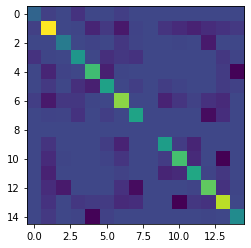

In [95]:
plt.imshow(L_heat)

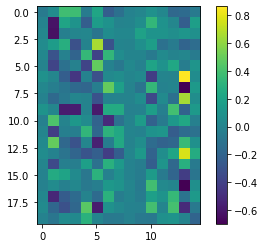

In [98]:
plt.imshow(H_heat[:20, :])
plt.colorbar()

In [111]:
L_smooth, *_ = GLSigRep(df.values, n_step=3000, alpha=1e-4, beta=1e-5)

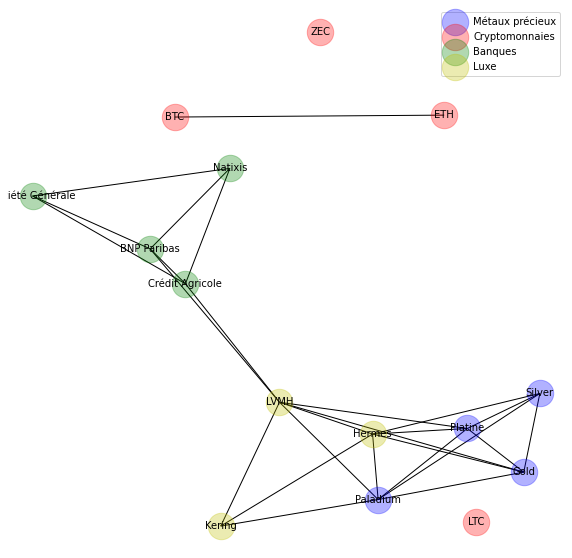

In [134]:
pruned_L_smooth = np.copy(L_smooth)
pruned_L_smooth[np.abs(L_smooth) < 0.001] = 0

G = nx.Graph()

for key in tickers.keys():
    G.add_node(key)

for i in range(len(keys_tickers)):
    for j in range(i+1, len(keys_tickers)):
        if pruned_L_smooth[i, j] != 0:
            G.add_edge(keys_tickers[i], keys_tickers[j])
            
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, k=1, scale=0.95)

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, nodelist=["Gold", "Silver", "Paladium", "Platine"], node_color="b", label="Métaux précieux", alpha=0.3, node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=["BTC", "LTC", "ZEC", "ETH"], node_color="r", label="Cryptomonnaies", alpha=0.3, node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=["BNP Paribas", "Crédit Agricole", "Société Générale", "Natixis"], node_color="g", label="Banques", alpha=0.3, node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=["Kering", "Hermes", "LVMH"], node_color="y", label="Luxe", alpha=0.3, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=10)
plt.legend()

plt.axis("off")
plt.show()

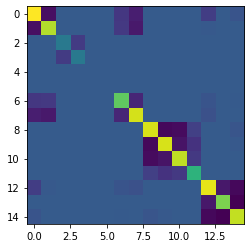

In [116]:
plt.imshow(L_smooth)

In [137]:
df.to_csv("financial_data.csv")